# Bibliotecas

In [1]:
import sys

sys.path.append('/eos/user/t/thenriqu/Dark_Matter/LGBM_hhdm_analysis/')

import json
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
import hepherolib.analysis as ana

from lgbm.controllers_lgb_v2 import LGBLearner, LGBModel
from lgbm.utils import model_performance, compute_purity_cutflow, compute_best_thr
from hhdm_analysis.utils import position, signal_label

ana.start()
plt.style.use("default")

# Configuração

In [2]:
period = '17'
year_style = 2017
dataset_year = "2017"
basedir = '/eos/user/t/thenriqu/Dark_Matter/Amostras/hhdmAnalysis_deepJet_Regions/datasets'

# Setup figure folders
dataset_name = basedir.split('/')[-2]
figures_path = f"./figures/{dataset_name}/{dataset_year}/machine_learning"
Path(figures_path).mkdir(parents=True, exist_ok=True)

# Data folder
data_path = f"./data/{dataset_name}/{dataset_year}"
Path(data_path).mkdir(parents=True, exist_ok=True)

# Setup models folders
models_path = f"./models/{dataset_name}/{dataset_year}"
Path(models_path).mkdir(parents=True, exist_ok=True)

# Lendo Metadata

In [3]:
with open('/eos/user/t/thenriqu/Dark_Matter/metadata.json', 'r') as f:
    metadata = json.load(f)

# Lendo Dados e Modelo

In [4]:
model_name = 'LGB_multi_signal'
plot_label = 'Multi-signal'

# Train and Test data
X_train = pd.read_csv(f'{data_path}/{model_name}-train-data.csv')
X_test = pd.read_csv(f'{data_path}/{model_name}-test-data.csv')

W_train = X_train.pop('modelWeight').values
W_test = X_test.pop('modelWeight').values

Y_train = X_train.pop('Label').values
Y_test = X_test.pop('Label').values

evtWeight_train = X_train.pop('evtWeight').values
evtWeight_teste = X_test.pop('evtWeight').values

# Model
features = ["LeadingLep_pt", "LepLep_deltaM", "LepLep_deltaR", "LepLep_pt", "MET_LepLep_Mt", "MET_LepLep_deltaPhi", "MET_pt", "MT2LL", "Nbjets", "TrailingLep_pt"]
model = LGBModel(model_fpath=f"{models_path}/{model_name}-clf.model")

# Predict do Treino e Teste

In [5]:
# Train
Y_pred_train = model.predict(X_train[features], features)
perf_train = model_performance(Y_train, Y_pred_train, n=1000)
ppv_train_cutflow = compute_purity_cutflow(perf_train.threshold, perf_train.fpr, perf_train.tpr, perf_train.ppv, perf_train.acc)
best_train_thr = compute_best_thr(perf_train.threshold, perf_train.tpr, perf_train.ppv)
ppv_train_cutflow.to_csv(f'{models_path}/{model_name}-ppv-train-cutflow.csv', index=False)


# Test
Y_pred_test = model.predict(X_test[features], features)
perf_test = model_performance(Y_test, Y_pred_test, n=1000)
ppv_test_cutflow = compute_purity_cutflow(perf_test.threshold, perf_test.fpr, perf_test.tpr, perf_test.ppv, perf_test.acc)
best_test_thr = compute_best_thr(perf_test.threshold, perf_test.tpr, perf_test.ppv)
ppv_test_cutflow.to_csv(f'{models_path}/{model_name}-ppv-test-cutflow.csv', index=False)

In [6]:
print('Best thr train:', best_train_thr)
display(ppv_train_cutflow)

Best thr train: 0.988988988988989


,purity_cut,purity,threshold,efficiency,bkg_rejection,accuracy
0,0.100000,0.100158,0.037037,0.999507,0.325360,0.372469
1,0.200000,0.200331,0.201201,0.990079,0.703082,0.723137
2,0.300000,0.300199,0.427427,0.972795,0.829630,0.839634
3,0.400000,0.400157,0.661662,0.949716,0.893043,0.897004
4,0.500000,0.500619,0.837838,0.921518,0.930939,0.930280
5,0.600000,0.600039,0.940941,0.882189,0.955822,0.950677
6,0.700000,0.701892,0.985986,0.810166,0.974149,0.962690
7,0.800000,0.812676,0.997998,0.642310,0.988877,0.964659
8,0.900000,0.076301,0.000000,1.000000,0.090499,0.154053
9,0.715803,0.715803,0.988989,0.795284,0.976278,0.963630


In [7]:
print('Best thr test', best_test_thr)
display(ppv_test_cutflow)

Best thr test 0.988988988988989


,purity_cut,purity,threshold,efficiency,bkg_rejection,accuracy
0,0.100000,0.100165,0.038038,0.993997,0.329115,0.375577
1,0.200000,0.200292,0.207207,0.975717,0.707309,0.726066
2,0.300000,0.300315,0.439439,0.958267,0.832262,0.841068
3,0.400000,0.400150,0.670671,0.938678,0.894280,0.897383
4,0.500000,0.500817,0.840841,0.914651,0.931506,0.930328
5,0.600000,0.601388,0.941942,0.877277,0.956313,0.950790
6,0.700000,0.703923,0.985986,0.808404,0.974454,0.962850
7,0.800000,0.811784,0.997998,0.642304,0.988811,0.964597
8,0.900000,0.076203,0.000000,0.999298,0.089842,0.153396
9,0.718284,0.718284,0.988989,0.793557,0.976616,0.963824


# Notificar quando terminar o teste

In [8]:
from IPython.display import clear_output, display, HTML, Javascript

display(Javascript("""
  var msg = new SpeechSynthesisUtterance();
  msg.text = "Process completed!";
  window.speechSynthesis.speak(msg);
  alert("Process completed!")
"""))

<IPython.core.display.Javascript object>

# Preparando dados para o Plot do Discriminate

In [9]:
scale_factor = 10**6

X_train['LGB_score'] = Y_pred_train
X_test['LGB_score'] = Y_pred_test

X_train['modelWeight'] = W_train/scale_factor
X_test['modelWeight'] = W_test/scale_factor

X_train['Label'] = Y_train
X_test['Label'] = Y_test

X_train["evtWeight"] = evtWeight_train
X_test['evtWeight'] = evtWeight_teste

# Plot do Discriminate usando modelWeigth

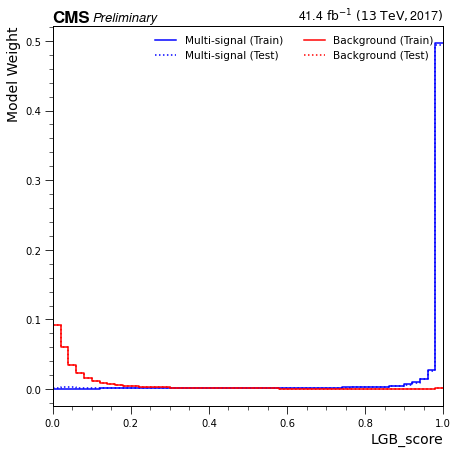

In [10]:
# Plot config
fig = plt.figure(figsize=(7,7))
grid = [1,1] # number of rows, number of cols
gspec = gs.GridSpec(grid[0], grid[1], width_ratios=[1], height_ratios=[1])

# Plot code
ax1 = plt.subplot(position(gspec, grid, main=1, sub=1)) # main is column number, sub is row number

ana.step_plot(ax1, "LGB_score", X_train[X_train.Label == 1], label=f"{plot_label} (Train)", color="blue", weight="modelWeight", bins=np.linspace(0, 1, 51))
ana.step_plot(ax1, "LGB_score", X_test[X_test.Label == 1], label=f"{plot_label} (Test)", color="blue", weight="modelWeight", bins=np.linspace(0, 1, 51), linestyle="dotted")
ana.step_plot(ax1, "LGB_score", X_train[X_train.Label == 0], label="Background (Train)", color="red", weight="modelWeight", bins=np.linspace(0, 1, 51))
ana.step_plot(ax1, "LGB_score", X_test[X_test.Label == 0], label="Background (Test)", color="red", weight="modelWeight", bins=np.linspace(0, 1, 51), linestyle="dotted")

ana.labels(ax1, ylabel="Model Weight", xlabel="LGB_score")
ana.style(
    ax1, lumi=metadata["luminosity"].get(dataset_year), year=year_style,
    ylog=False, legend_ncol=2, #ylim=[0, 1]
)
plt.savefig(f"{figures_path}/LGB_score-modelWeight-{model_name}.png", dpi=200, facecolor='white')
plt.show()

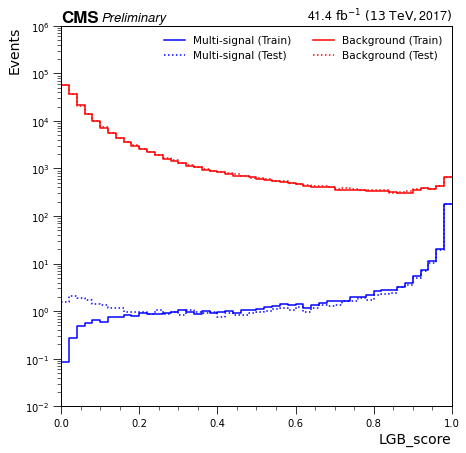

In [11]:
# Plot config
fig = plt.figure(figsize=(7,7))
grid = [1,1] # number of rows, number of cols
gspec = gs.GridSpec(grid[0], grid[1], width_ratios=[1], height_ratios=[1])

# Plot code
ax1 = plt.subplot(position(gspec, grid, main=1, sub=1)) # main is column number, sub is row number

ana.step_plot(ax1, "LGB_score", X_train[X_train.Label == 1], label=f"{plot_label} (Train)", color="blue", weight="evtWeight", bins=np.linspace(0, 1, 51))
ana.step_plot(ax1, "LGB_score", X_test[X_test.Label == 1], label=f"{plot_label} (Test)", color="blue", weight="evtWeight", bins=np.linspace(0, 1, 51), linestyle="dotted")
ana.step_plot(ax1, "LGB_score", X_train[X_train.Label == 0], label="Background (Train)", color="red", weight="evtWeight", bins=np.linspace(0, 1, 51))
ana.step_plot(ax1, "LGB_score", X_test[X_test.Label == 0], label="Background (Test)", color="red", weight="evtWeight", bins=np.linspace(0, 1, 51), linestyle="dotted")

ana.labels(ax1, ylabel="Events", xlabel="LGB_score")
ana.style(
    ax1, lumi=metadata["luminosity"].get(dataset_year), year=year_style,
    ylog=True, legend_ncol=2, ylim=[1e-2, 1e6]
)
plt.savefig(f"{figures_path}/LGB_score-evtWeight-{model_name}.png", dpi=200, facecolor='white')
plt.show()